In [1]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
# Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
# preproceessing
from model_transformers2 import FeaturesInteractions,SkewTransformer,ZeroThreshold

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.model_selection import RepeatedKFold,GridSearchCV,KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer

from sklearn.externals import joblib

# sklearn classes
from stacking_models import StackingAveragedModels,AveragingModels

from mlxtend.regressor import StackingCVRegressor

In [2]:
#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [3]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)     

# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

# Drop outliers
train = train.drop(train[(train['van_der_waals_change']>3)].index)
train = train.drop(train[(train['dg_change'].abs()>8)].index)

y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

In [4]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# Modelling

#### Crossvalidation strategy

In [5]:
def cv_results(cv_object):
    
    # scores
    rmse_train_cv = np.sqrt(-cv_object["train_neg_mean_squared_error"])
    rmse_test_cv = np.sqrt(-cv_object["test_neg_mean_squared_error"])
    r2_train_cv = cv_object["train_r2"]
    r2_test_cv = cv_object["test_r2"]
    
    print("RMSE train CV: {:.4f} ({:.4f})".format(rmse_train_cv.mean(),rmse_train_cv.std()))
    print("RMSE test CV: {:.4f} ({:.4f})".format(rmse_test_cv.mean(),rmse_test_cv.std()))
    print('DIFF RMSE {}\n'.format(rmse_test_cv.mean()-rmse_train_cv.mean()))

    print("r2 train CV: {:.4f} ({:.4f})".format(r2_train_cv.mean(),r2_train_cv.std()))
    print("r2 test CV: {:.4f} ({:.4f})".format(r2_test_cv.mean(),r2_test_cv.std()))
    print('DIFF RMSE {}\n'.format(r2_test_cv.mean()-r2_train_cv.mean()))
    
def test_results(fitted_estimator,Xtest,Ytest):
    y_test_pred = fitted_estimator.predict(Xtest)
    #y_train_pred = fitted_estimator.predict(Xtrain)
    
    print("RMSE test: {}".format(np.round(np.sqrt(mean_squared_error(Ytest, y_test_pred)), 2)))

    print('r2 test',r2_score(Ytest,y_test_pred))
    #print('r2 train',r2_score(Ytrain,y_train_pred))
    
    print("Pearson corr test {:f}".format(np.corrcoef(y_test_pred,Ytest.ravel())[0][1]))
    

In [6]:
#Validation function
n_folds = 10

def evaluating(model,Xtrain,Ytarget):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain)
    #rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2","neg_mean_squared_error"],
                             cv = kf,verbose=1,n_jobs=-1,return_train_score=True,return_estimator=True)
    return cvscore

def evaluating2(model,Xtrain,Ytarget):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain.values)
    #rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2","neg_mean_squared_error"],
                             cv = kf,verbose=1,n_jobs=-1,return_train_score=True,return_estimator=True)
    return cvscore

In [7]:
# preprocess pipeline steps
#steps pipeline
interactions = FeaturesInteractions(features1=range(15),feature2=20)
skewness = SkewTransformer(threshold=0.6)
zeroth = ZeroThreshold(threshold=90.)

#### algorithms

In [8]:
#lasso model
lasso = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.001,normalize=True,fit_intercept=True,random_state=1))
# svr polynomial kernel
svrP = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly'))

svrRBF = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=2.5,epsilon=0.5,gamma=2,kernel='rbf'))

gbt = make_pipeline(interactions,skewness,zeroth,
                   GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=8, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.7))

xgbr = make_pipeline(interactions,skewness,zeroth,
                   XGBRegressor(colsample_bytree=0.6, gamma=0, 
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=0.000005, reg_lambda=200,
                             subsample=0.9,random_state =7, nthread = -1))


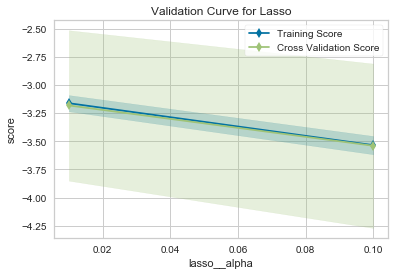

0


In [269]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
#2)
#3) Crear pipeline

viz = ValidationCurve(
    lasso, njobs=-1,param_name="lasso__alpha",
    param_range=[0.01,0.1], cv=10, scoring="neg_mean_squared_error",n_jobs=-1)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train.values, y_train.values)
viz.poof()
print(viz.test_scores_mean_.argmax())

In [77]:
np.sqrt(-viz.test_scores_mean_)

array([1.58978938, 1.58838006, 1.5870186 , 1.58659171, 1.5865904 ])

#### Base model scores

In [9]:
print('Lasso Model Evaluation')
lassocv = evaluating(lasso,X_train.values,y_train.values)
cv_results(lassocv)

lasso_model = lasso.fit(X_train.values,y_train.values)
test_results(lasso_model,X_test.values,y_test.values)


Lasso Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


RMSE train CV: 1.6837 (0.0201)
RMSE test CV: 1.7266 (0.1940)
DIFF RMSE 0.04282956970089091

r2 train CV: 0.1979 (0.0106)
r2 test CV: 0.1433 (0.0634)
DIFF RMSE -0.05458616098603905

RMSE test: 1.72
r2 test 0.2545560277590526
Pearson corr test 0.531932


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished


In [10]:
print('XGBRegressor Model Evaluation')
xgbrcv = evaluating(xgbr,X_train.values,y_train.values)
cv_results(xgbrcv)

xgbr_model = xgbr.fit(X_train.values,y_train.values)
test_results(xgbr_model,X_test.values,y_test.values)


XGBRegressor Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.9s finished


RMSE train CV: 0.3147 (0.0067)
RMSE test CV: 1.5882 (0.1748)
DIFF RMSE 1.273463790410228

r2 train CV: 0.9720 (0.0009)
r2 test CV: 0.2731 (0.0726)
DIFF RMSE -0.6988767594699632

RMSE test: 1.63
r2 test 0.3341663130064477
Pearson corr test 0.578828


In [11]:
print('SVR polynomial Model Evaluation')
svrPcv = evaluating(svrP,X_train.values,y_train.values)
cv_results(svrPcv)

svrP_model = xgbr.fit(X_train.values,y_train.values)
test_results(svrP_model,X_test.values,y_test.values)

SVR polynomial Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


RMSE train CV: 1.5361 (0.0194)
RMSE test CV: 1.7183 (0.1800)
DIFF RMSE 0.18223809293496052

r2 train CV: 0.3323 (0.0102)
r2 test CV: 0.1482 (0.0860)
DIFF RMSE -0.18417805910690158

RMSE test: 1.63
r2 test 0.3341663130064477
Pearson corr test 0.578828


In [12]:
print('SVR rbf Model Evaluation')
svrRBFcv = evaluating(svrRBF,X_train.values,y_train.values)
cv_results(svrRBFcv)

svrRBF_model = svrRBF.fit(X_train.values,y_train.values)
test_results(svrRBF_model,X_test.values,y_test.values)

SVR rbf Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


RMSE train CV: 1.0740 (0.0239)
RMSE test CV: 1.6600 (0.2132)
DIFF RMSE 0.5859492179580619

r2 train CV: 0.6735 (0.0115)
r2 test CV: 0.2100 (0.0631)
DIFF RMSE -0.46354921596518606

RMSE test: 1.77
r2 test 0.20999894242033712
Pearson corr test 0.463938


In [13]:
print('GradientBoostingRegressor Model Evaluation')
gbtcv = evaluating(gbt,X_train.values,y_train.values)
cv_results(gbtcv)

gbt_model = gbt.fit(X_train.values,y_train.values)
test_results(gbt_model,X_test.values,y_test.values)

GradientBoostingRegressor Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.0s finished


RMSE train CV: 0.7140 (0.0182)
RMSE test CV: 1.6050 (0.1778)
DIFF RMSE 0.8909998247735672

r2 train CV: 0.8557 (0.0062)
r2 test CV: 0.2575 (0.0762)
DIFF RMSE -0.5981599020116533

RMSE test: 1.62
r2 test 0.34190081814183626
Pearson corr test 0.597927


In [14]:
print('Averaged Models Evaluation')
averaged_models = AveragingModels(models = (gbt, svrP,xgbr,svrRBF, lasso))

averaged_models_cv = evaluating(averaged_models,X_train.values,y_train.values)
cv_results(averaged_models_cv)

averaged_models_model = averaged_models.fit(X_train.values,y_train.values)
test_results(averaged_models_model,X_test.values,y_test.values)

Averaged Models Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.8s finished


RMSE train CV: 1.0079 (0.0159)
RMSE test CV: 1.6038 (0.1891)
DIFF RMSE 0.5959783389051654

r2 train CV: 0.7126 (0.0062)
r2 test CV: 0.2608 (0.0652)
DIFF RMSE -0.45175036441399186

RMSE test: 1.64
r2 test 0.322696830237302
Pearson corr test 0.603064


In [15]:
final_avg = averaged_models.fit(full_data.values,y_full.values)
from sklearn.externals import joblib

# save final model

joblib.dump(final_avg, 'avg_models_FINAL.pkl')

['avg_models_FINAL.pkl']

In [13]:
lassoMeta = make_pipeline(MinMaxScaler(), Lasso(alpha =0.001, random_state=1,normalize=True,fit_intercept=True))
svrMeta = make_pipeline(make_pipeline(MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly')))

xgbMeta = make_pipeline(make_pipeline(XGBRegressor(colsample_bytree=0.6, gamma=0, 
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=0.000005, reg_lambda=200,
                             subsample=0.9,random_state =7, nthread = -1)))

gbtMeta = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=8, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.7)

In [14]:
stacked_averaged_models = StackingAveragedModels(base_models = (gbt, svrP,svrRBF,xgbr),
                                                 meta_model = svrMeta)

In [69]:
print('Averaged Stacked Models Evaluation')

stacked_averaged_models_cv = evaluating(stacked_averaged_models,X_train.values,y_train.values)
cv_results(stacked_averaged_models_cv)

stacked_averaged_models_model = stacked_averaged_models.fit(X_train.values,y_train.values)
test_results(stacked_averaged_models_model,X_test.values,y_test.values)

Averaged Stacked Models Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


RMSE train CV: 0.9740 (0.0482)
RMSE test CV: 1.6081 (0.1901)
DIFF RMSE 0.6340602964945962

r2 train CV: 0.7309 (0.0264)
r2 test CV: 0.2573 (0.0598)
DIFF RMSE -0.4735539192313503

RMSE test: 1.65
r2 test 0.3116774906157096
Pearson corr test 0.580218


In [11]:
final_stacked_averaged_models = stacked_averaged_models.fit(full_data.values,y_full.values)

In [12]:
from sklearn.externals import joblib

# save final model

joblib.dump(final_stacked_averaged_models, 'stacked_averaged_models_FINAL.v3.pkl')

['stacked_averaged_models_FINAL.v3.pkl']